In [24]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Citation table

We take cites from 1990 to 2019 avoiding self-cites.

In [25]:
cite = pd.read_csv("../data/processed/cites.csv")

cite = cite[(cite.t_year >= 1990) & (cite.t_year < 2020)]
cite = cite[(cite.s_year >= 1990) & (cite.s_year < 2020)]

cite = cite[cite.target != cite.source]

In [26]:
papers = pd.read_csv("../data/processed/adjacency_papers.csv")

papers = papers[(papers.t_year >= 1990) & (papers.t_year < 2020)]
papers = papers[(papers.s_year >= 1990) & (papers.s_year < 2020)]

papers = papers[papers.target != papers.source]

### Authors table

There are two author tables: 

1. One with the comparable groups A and B (`people`) and 
2. the one with the all the authors found in the RePEc repository (`all_people`).

In [27]:
people = pd.read_csv("../data/processed/network_people.csv")
all_people = pd.read_csv("../data/processed/people.csv")

### Places table

We use the institution to infer the place of work of the authors. We have:

1. The region (continent)
2. The sub-region (sub-continent)
3. Country 3-letter code
4. The institution's name

In [28]:
places = pd.read_csv("../data/processed/institution.csv")

places = places[['Handle', 'Primary-Name', 'alpha-3', 'region', 'sub-region']].set_index("Handle")

### Adding place of work to people

In [29]:
all_people = pd.merge(all_people,
                  places,
                  left_on="Workplace-Institution",
                  right_index=True,
                  how="left")

# all_people = all_people[all_people.region.notna()]

### Adding gender to the citation table

We have two genders for each cite:

1. Gender of the source (`gender_s`)
3. Gender of the target (`gender`)

In [30]:
cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]],
                how="left",
                left_on="target",
                right_on="Short-Id")

cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]].rename(columns={"gender":"gender_s"}),
                how="left",
                left_on="source",
                right_on="Short-Id")

Let's remove the citations without the gender of the target from the table.

In [31]:
cite = cite[cite.gender.notna()]
cite = cite[cite.gender_s.notna()]

In [32]:
all_people.gender.value_counts(normalize=True)

male      0.732679
female    0.267321
Name: gender, dtype: float64

In [33]:
cite

,paper,target,t_year,t_journal,source,s_year,s_journal,Short-Id_x,gender,Short-Id_y,gender_s
0,repec:aag:wpaper:v:22:y:2018:i:1:p:180-203,pal66,2018.0,repec:aag:wpaper,pmc90,2019.0,repec:gam:jsusta,pal66,male,pmc90,male
1,repec:aag:wpaper:v:22:y:2018:i:1:p:180-203,pmc90,2018.0,repec:aag:wpaper,pal66,2019.0,repec:gam:jsusta,pmc90,male,pal66,male
3,repec:abz:journl:y:2015:id:26,pba1182,2015.0,repec:abz:journl,pze104,2016.0,repec:abz:journl,pba1182,female,pze104,male
4,repec:abz:journl:y:2015:id:26,pze104,2015.0,repec:abz:journl,pba1182,2016.0,repec:abz:journl,pze104,male,pba1182,female
5,repec:acb:agenda:v:10:y:2003:i:1:p:27-41,pfi172,2003.0,repec:acb:agenda,pwh34,2010.0,repec:bla:ecorec,pfi172,male,pwh34,male
...,...,...,...,...,...,...,...,...,...,...,...
4917349,repec:zbw:zewwka:126032,pra457,2011.0,repec:zbw:zewwka,phu420,2015.0,repec:eee:respol,pra457,male,phu420,male
4917350,repec:zbw:zewwka:126032,pra457,2011.0,repec:zbw:zewwka,phu86,2015.0,repec:eee:respol,pra457,male,phu86,female
4917353,repec:bla:reviec:v:13:y:2005:i:5:p:973-984,pba308,2005.0,repec:bla:reviec,pwe284,2008.0,repec:eee:eneeco,pba308,male,pwe284,male
4917354,repec:bla:reviec:v:13:y:2005:i:5:p:973-984,pfo91,2005.0,repec:bla:reviec,pwe284,2008.0,repec:eee:eneeco,pfo91,male,pwe284,male


## Super-cited researchers

Let's get some basic statistics of the super-cited researchers in our citation network.

In [34]:
G_cite = nx.from_pandas_edgelist(cite,
                            source='source',
                            target='target',
                            create_using=nx.DiGraph)

In [35]:
len(G_cite)

36665

In [36]:
degree = pd.DataFrame(G_cite.in_degree(), columns=["author", "degree"])
mu = degree.degree.mean()
r = degree.degree.quantile(.75) - degree.degree.quantile(.25)

In [37]:
super_cited = degree[degree.degree >= mu + 1.5 * r].author.unique()
cite_sc = cite[cite.target.isin(super_cited)]

## Collaboration network

In [38]:
col = pd.read_csv("../data/processed/co_author.csv")

In [39]:
col.year.unique()

array([2004., 2008., 2010., 2013., 2018., 1989., 1990., 2011., 2012.,
       1981., 2006., 2007., 2009., 2014., 2015., 2019., 2001., 2016.,
       2017., 2003., 2002., 1994., 1995., 1997., 2000., 1982., 1969.,
       2020., 1993., 1999., 1979., 1983., 1991., 2005.,   nan, 1984.,
       1992., 1985., 1987., 1972., 1988., 1998., 1996., 1980., 1976.,
       1986., 1973., 1970., 1977., 1978., 1975., 1974., 1966., 1957.,
       1961., 1971., 1968., 1967., 1958., 1956., 1942., 1955., 1954.,
       1962.])

In [40]:
col = col[(col.year >= 1990) & (col.year < 2020)]

## Add gender to collaboration network

In [41]:
col = pd.merge(col,
               all_people[['Short-Id', 'gender']],
               left_on='author1',
               right_on='Short-Id',
               how='left')
col = pd.merge(col,
               all_people[['Short-Id', 'gender']],
               left_on='author2',
               right_on='Short-Id',
               suffixes=["_1", "_2"],
               how='left')

In [42]:
col = col.dropna(subset=['gender_1', 'gender_2'])

In [52]:
col.head()

,author1,author2,article,year,journal,journal_name,title,Short-Id_1,gender_1,Short-Id_2,gender_2
1,pfo27,pnd1,repec:oup:jafrec:v:13:y:2004:i:02:p:ii1-ii14,2004.0,repec:oup:jafrec,Journal of African Economies,Africa and the World Economy,pfo27,male,pnd1,male
4,pbr37,pnd1,repec:bpj:globdv:v:1:y:2010:i:1:n:16,2010.0,repec:bpj:globdv,Journal of Globalization and Development,Africa,pbr37,female,pnd1,male
5,pnt11,pnd1,repec:aea:aecrev:v:103:y:2013:i:3:p:293-97,2013.0,repec:aea:aecrev,American Economic Review,Access to Credit by Firms in Sub-Saharan Africa,pnt11,male,pnd1,male
6,pas229,pnd1,repec:aea:aecrev:v:103:y:2013:i:3:p:293-97,2013.0,repec:aea:aecrev,American Economic Review,Access to Credit by Firms in Sub-Saharan Africa,pas229,female,pnd1,male
7,pka799,pnd1,repec:aea:aecrev:v:103:y:2013:i:3:p:293-97,2013.0,repec:aea:aecrev,American Economic Review,Access to Credit by Firms in Sub-Saharan Africa,pka799,male,pnd1,male


In [55]:
fem = []
for year in range(2009, 2020):
    chunk = col[col.year==year]
    n = set(chunk.author1.unique()) | set(chunk.author2.unique())
    p = all_people[all_people['Short-Id'].isin(n)]
    fem.append(p.gender.value_counts(normalize=True).loc['female'])
    

In [56]:
print(np.mean(fem), np.std(fem))

0.21831566210295306 0.004305070491037127


## Let's look at the network structure of the super_cited

In [18]:
genders = dict(zip(all_people['Short-Id'], all_people['gender']))

In [19]:
G = nx.from_pandas_edgelist(col,
                            source='author1',
                            target='author2')

In [20]:
nx.set_node_attributes(G, genders, 'gender')

In [21]:
nx.attribute_assortativity_coefficient(G, 'gender')

0.11035765099204055

### Basic stats

Let's compare to the citation network

In [22]:
len(G.edges)

80308

In [23]:
v_col = set(list(G))
v_cite = set(list(G_cite))

In [24]:
len(v_col)

31517

In [25]:
len(v_cite)

36665

In [26]:
len(v_col & v_cite) / len(v_col)

0.9503759875622679

In [27]:
degree = pd.DataFrame(G.degree, columns=['author', 'degree'])

In [28]:
degree.describe()

,degree
count,31517.000000
mean,5.096170
std,6.034275
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,98.000000


In [29]:
nx.number_connected_components(G)

968

### By group of researchers

Group A

In [30]:
G_A = G.subgraph(people[people['group']=='A']['Short-Id'].unique())

print("Nodes: ", len(G_A))

print("Edges: ", len(G_A.edges))

degree = pd.DataFrame(G_A.degree, columns=['author', 'degree'])

print(degree.describe())

print("AAC: ", nx.attribute_assortativity_coefficient(G_A, 'gender'))
print("Connected components: ", nx.number_connected_components(G_A))

Nodes:  6898
Edges:  2396
            degree
count  6898.000000
mean      0.694694
std       1.036595
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      12.000000
AAC:  0.12263788884389894
Connected components:  4772


Group B

In [31]:
G_B = G.subgraph(people[people['group']=='B']['Short-Id'].unique())

print("Nodes: ", len(G_B))

print("Edges: ", len(G_B.edges))

degree = pd.DataFrame(G_B.degree, columns=['author', 'degree'])

print(degree.describe())

print("AAC: ", nx.attribute_assortativity_coefficient(G_B, 'gender'))
print("Connected components: ", nx.number_connected_components(G_B))

Nodes:  1381
Edges:  727
            degree
count  1381.000000
mean      1.052860
std       1.196354
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       8.000000
AAC:  0.11686103012633632
Connected components:  723


Super-cited

In [32]:
G_SC = G.subgraph(super_cited)

print("Nodes: ", len(G_SC))

print("Edges: ", len(G_SC.edges))

degree = pd.DataFrame(G_SC.degree, columns=['author', 'degree'])

print(degree.describe())

print("AAC: ", nx.attribute_assortativity_coefficient(G_SC, 'gender'))
print("Connected components: ", nx.number_connected_components(G_SC))

Nodes:  4091
Edges:  13527
            degree
count  4091.000000
mean      6.613053
std       5.296824
min       0.000000
25%       3.000000
50%       5.000000
75%       8.000000
max      64.000000
AAC:  0.06491726097390577
Connected components:  89


## Who is connected to the super-cited group?

First, let's get the group of super-cited researchers each year.

In [50]:
years = []
super_cited = []
for year in [2000, 2003] + list(range(2005, 2020)):
    years.append(year)
    if year == 2000:
        chunk = cite[cite.s_year <= year]
    elif year == 2003:
        chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003)]
    elif year == 2005:
        chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005)]
    else:
        chunk = cite[cite.s_year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="source",
                                     target="target",
                                     create_using=nx.DiGraph)
    degree = pd.DataFrame(G_year.in_degree(), columns=["author", "degree"])
    mu = degree.degree.mean()
    r = degree.degree.quantile(.75) - degree.degree.quantile(.25)
    scited = degree[degree.degree >= mu + 1.5 * r].author.unique()
    super_cited.append(set(scited))

Now, let's look at the cumulative intersection of super-cited researchers.

In [34]:
cum_int = [1]
main = super_cited[-1]
a = len(main)
for sc in super_cited[-2::-1]:
    main = sc & main
    cum_int.append(len(main) / a)

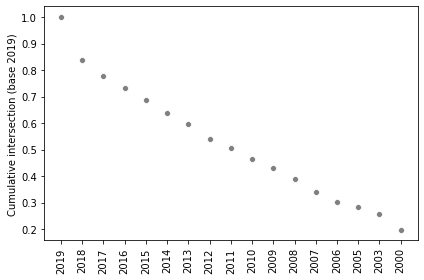

In [35]:
sns.scatterplot(x=[str(y) for y in years[-1::-1]], y=cum_int, color='gray')
plt.xticks(rotation=90)
plt.ylabel("Cumulative intersection (base 2019)")
plt.tight_layout()
plt.savefig("../figures/super_cited_cum_int_2019.png", dpi=300)

Let's get the first neighbors of the super-cited each year

One year from now

In [51]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-1]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     create_using=nx.Graph)
    n = []
    for sc in super_cited[i]:
        if sc in G_year:
            n.extend(list(G_year[sc]))
    n = (set(n) - super_cited[i])
    print(all_people[all_people['Short-Id'].isin(n)]['gender'].value_counts(normalize=True))
    not_n = set(list(G_year)) - n - super_cited[i] 
    neighbors.append(len(n & super_cited[i+1]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+1]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

male      0.87037
female    0.12963
Name: gender, dtype: float64
male      0.830291
female    0.169709
Name: gender, dtype: float64
male      0.818423
female    0.181577
Name: gender, dtype: float64
male      0.809129
female    0.190871
Name: gender, dtype: float64
male      0.813453
female    0.186547
Name: gender, dtype: float64
male      0.786184
female    0.213816
Name: gender, dtype: float64
male      0.781766
female    0.218234
Name: gender, dtype: float64
male      0.787025
female    0.212975
Name: gender, dtype: float64
male      0.790247
female    0.209753
Name: gender, dtype: float64
male      0.772855
female    0.227145
Name: gender, dtype: float64
male      0.780876
female    0.219124
Name: gender, dtype: float64
male      0.787544
female    0.212456
Name: gender, dtype: float64
male      0.759534
female    0.240466
Name: gender, dtype: float64
male      0.770657
female    0.229343
Name: gender, dtype: float64
male      0.782946
female    0.217054
Name: gender, dtype: float

In [1]:
fem = [0.223772, 0.217054, 0.229343, 0.240466, 0.212456, 0.219124, 0.227145, 0.209753, 0.212975, 0.218234]

In [3]:
print(np.mean(fem), np.std(fem))

0.2210322 0.008857776603640444


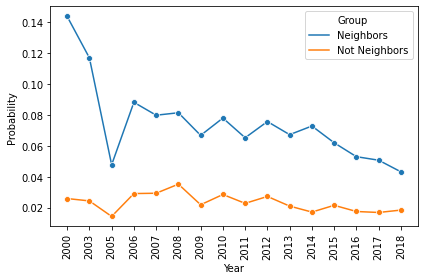

In [37]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/probability_1_year.png", dpi=300)

2 Years from now

In [38]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-2]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     create_using=nx.Graph)
    n = []
    for sc in super_cited[i]:
        if sc in G_year:
            n.extend(list(G_year[sc]))
    n = (set(n) - super_cited[i])
    not_n = set(list(G_year)) - n - super_cited[i] 
    neighbors.append(len(n & super_cited[i+2]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+2]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

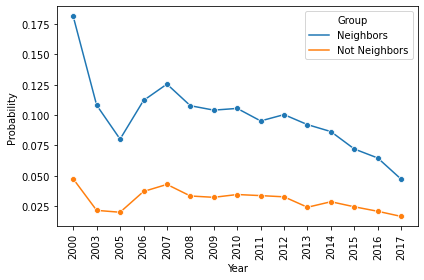

In [39]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/probability_2_years.png", dpi=300)

3 Years from now

In [40]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-3]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     create_using=nx.Graph)
    n = []
    for sc in super_cited[i]:
        if sc in G_year:
            n.extend(list(G_year[sc]))
    n = (set(n) - super_cited[i])
    not_n = set(list(G_year)) - n - super_cited[i] 
    neighbors.append(len(n & super_cited[i+3]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+3]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

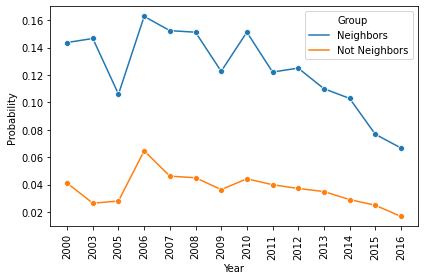

In [41]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/probability_3_years.png", dpi=300)

5 Years from now

In [42]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-5]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     create_using=nx.Graph)
    n = []
    for sc in super_cited[i]:
        if sc in G_year:
            n.extend(list(G_year[sc]))
    n = (set(n) - super_cited[i])
    not_n = set(list(G_year)) - n - super_cited[i] 
    neighbors.append(len(n & super_cited[i+5]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+5]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

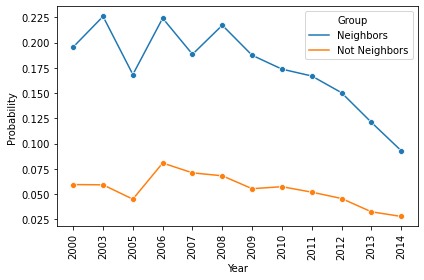

In [43]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/probability_5_years.png", dpi=300)

# Strongly connected to the super-cited

Let's investigate the people that have strong ties with the super-cited researchers.

In [44]:
col_w = col.groupby(['author1', 'author2']).size().rename('weight').reset_index()

In [45]:
G_w = nx.from_pandas_edgelist(col_w,
                              source='author1',
                              target='author2',
                              edge_attr='weight')

### 1 year after

In [46]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-1]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    chunk = chunk.groupby(['author1', 'author2']).size().rename('weight').reset_index()
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     edge_attr='weight',
                                     create_using=nx.Graph)
    degree_year = pd.DataFrame(G_year.degree(weight='weight'), columns=['author', 'degree'])
    median = degree_year.degree.mean()
    dic_neighbors = {}
    for sc in super_cited[i]:
        if sc in G_year:
            for u in G_year[sc]:
                w = G_year[sc][u]['weight']
                dic_neighbors.setdefault(u, [])
                dic_neighbors[u].append(w)
    dic_neighbors = {u: sum(dic_neighbors[u]) for u in dic_neighbors if sum(dic_neighbors[u]) >= median}
    n = set(dic_neighbors.keys())
    n = (n - super_cited[i])
    not_n = set(list(G_year)) - n - super_cited[i] 
    neighbors.append(len(n & super_cited[i+1]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+1]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

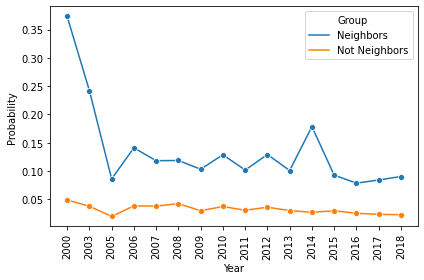

In [47]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/probability_collaborations_1_year.png", dpi=300)

## 5 Years

In [48]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-5]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    chunk = chunk.groupby(['author1', 'author2']).size().rename('weight').reset_index()
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     edge_attr='weight',
                                     create_using=nx.Graph)
    degree_year = pd.DataFrame(G_year.degree(weight='weight'), columns=['author', 'degree'])
    median = degree_year.degree.mean()
    dic_neighbors = {}
    for sc in super_cited[i]:
        if sc in G_year:
            for u in G_year[sc]:
                w = G_year[sc][u]['weight']
                dic_neighbors.setdefault(u, [])
                dic_neighbors[u].append(w)
    dic_neighbors = {u: sum(dic_neighbors[u]) for u in dic_neighbors if sum(dic_neighbors[u]) >= median}
    n = set(dic_neighbors.keys())
    n = (n - super_cited[i])
    not_n = set(list(G_year)) - n - super_cited[i] 
    neighbors.append(len(n & super_cited[i+5]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+5]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

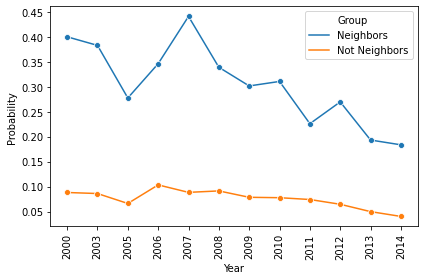

In [49]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/probability_collaborations_5_years.png", dpi=300)

## How diversified you are in the super-cited group?

## After 1 year

In [50]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-1]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    chunk = chunk.groupby(['author1', 'author2']).size().rename('weight').reset_index()
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     edge_attr='weight',
                                     create_using=nx.Graph)
    dic_neighbors = {}
    for sc in super_cited[i]:
        if sc in G_year:
            for u in G_year[sc]:
                dic_neighbors.setdefault(u, [])
                dic_neighbors[u].append(sc)
    dic_neighbors = {u: len(dic_neighbors[u]) for u in dic_neighbors}
    mean = np.mean(list(dic_neighbors.values()))
    n = {u for u in dic_neighbors if dic_neighbors[u] >= mean}
    n = (n - super_cited[i])
    not_n = set(list(G_year)) - n - super_cited[i] 
    neighbors.append(len(n & super_cited[i+1]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+1]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

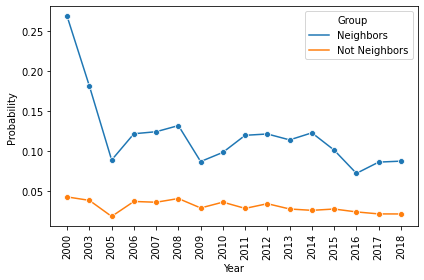

In [51]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/probability_neighbors_1_year.png", dpi=300)

## After 5 years

In [52]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-5]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    chunk = chunk.groupby(['author1', 'author2']).size().rename('weight').reset_index()
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     edge_attr='weight',
                                     create_using=nx.Graph)
    dic_neighbors = {}
    for sc in super_cited[i]:
        if sc in G_year:
            for u in G_year[sc]:
                dic_neighbors.setdefault(u, [])
                dic_neighbors[u].append(sc)
    dic_neighbors = {u: len(dic_neighbors[u]) for u in dic_neighbors}
    mean = np.mean(list(dic_neighbors.values()))
    n = {u for u in dic_neighbors if dic_neighbors[u] >= mean}
    n = (n - super_cited[i])
    not_n = set(list(G_year)) - n - super_cited[i] 
    neighbors.append(len(n & super_cited[i+5]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+5]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

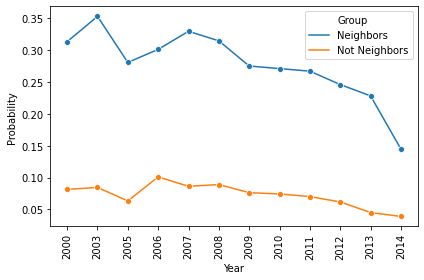

In [53]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/probability_neighbors_5_years.png", dpi=300)

## People never appearing in the super-cited club

## All colaborators

### After 1 year

In [82]:
neighbors = []
not_neighbors = []
women = []
for i, year in enumerate(years[:-1]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     create_using=nx.Graph)
    n = []
    for sc in super_cited[i]:
        if sc in G_year:
            n.extend(list(G_year[sc]))
    n = set(n)
    if i == 0:
        n = n - super_cited[i]
        not_n = set(list(G_year)) - n - super_cited[i] 
    else:
        for j in range(0, i+1):
            n = n - super_cited[j]
            not_n = set(list(G_year)) - n - super_cited[j]
    women.append([str(years[i]), "Neighbor", all_people[all_people['Short-Id'].isin(n)]['gender'].value_counts(normalize=True).loc['female']])
    women.append([str(years[i]), "Not Neighbor", all_people[all_people['Short-Id'].isin(not_n)]['gender'].value_counts(normalize=True).loc['female']])
    women.append([str(years[i]), "Neighbor Elite + 1", all_people[all_people['Short-Id'].isin(n & super_cited[i+1])]['gender'].value_counts(normalize=True).loc['female']])
    women.append([str(years[i]), "Not-Neighbor Elite + 1", all_people[all_people['Short-Id'].isin(not_n & super_cited[i+1])]['gender'].value_counts(normalize=True).loc['female']])
    neighbors.append(len(n & super_cited[i+1]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+1]) / len(not_n))
    

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])
df_women_1 = pd.DataFrame(women, columns=['Year', 'Type', 'Proportion'])

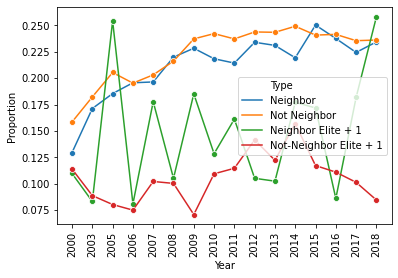

In [83]:
sns.lineplot(x='Year', y='Proportion', hue="Type", data=df_women_1, marker="o")
plt.xticks(rotation=90);

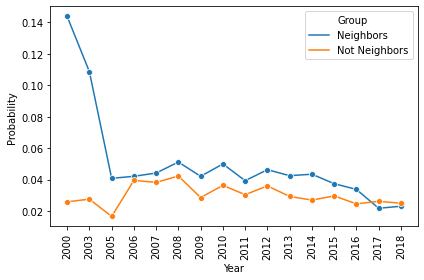

In [55]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()

## 5 years in the future

In [78]:
neighbors = []
not_neighbors = []
women = []
for i, year in enumerate(years[:-5]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     create_using=nx.Graph)
    n = []
    for sc in super_cited[i]:
        if sc in G_year:
            n.extend(list(G_year[sc]))
    n = set(n)
    if i == 0:
        n = n - super_cited[i]
        not_n = set(list(G_year)) - n - super_cited[i] 
    else:
        for j in range(0, i+1):
            n = n - super_cited[j]
            not_n = set(list(G_year)) - n - super_cited[j]
    neighbors.append(len(n & super_cited[i+5]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+5]) / len(not_n))
    women.append([str(years[i]), "Neighbor", all_people[all_people['Short-Id'].isin(n)]['gender'].value_counts(normalize=True).loc['female']])
    women.append([str(years[i]), "Not Neighbor", all_people[all_people['Short-Id'].isin(not_n)]['gender'].value_counts(normalize=True).loc['female']])
    women.append([str(years[i]), "Neighbor Elite + 5", all_people[all_people['Short-Id'].isin(n & super_cited[i+5])]['gender'].value_counts(normalize=True).loc['female']])
    women.append([str(years[i]), "Not-Neighbor Elite + 5", all_people[all_people['Short-Id'].isin(not_n & super_cited[i+5])]['gender'].value_counts(normalize=True).loc['female']])


    

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])
df_women_5 = pd.DataFrame(women, columns=['Year', 'Type', 'Proportion'])

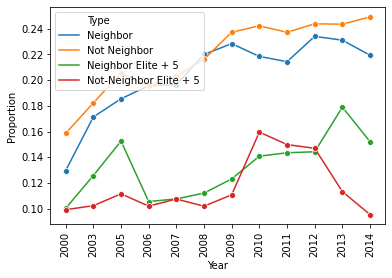

In [79]:
sns.lineplot(x='Year', y='Proportion', hue="Type", data=df_women_5, marker="o")
plt.xticks(rotation=90);

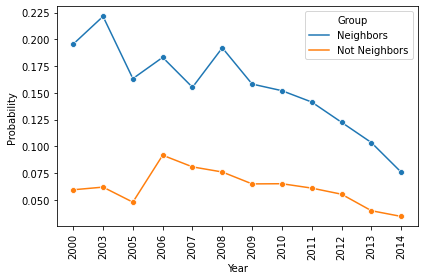

In [57]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()

# Strongly connected to the super-cited

Let's investigate the people that have strong ties with the super-cited researchers.

### 1 year after

In [58]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-1]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    chunk = chunk.groupby(['author1', 'author2']).size().rename('weight').reset_index()
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     edge_attr='weight',
                                     create_using=nx.Graph)
    degree_year = pd.DataFrame(G_year.degree(weight='weight'), columns=['author', 'degree'])
    median = degree_year.degree.mean()
    dic_neighbors = {}
    for sc in super_cited[i]:
        if sc in G_year:
            for u in G_year[sc]:
                w = G_year[sc][u]['weight']
                dic_neighbors.setdefault(u, [])
                dic_neighbors[u].append(w)
    dic_neighbors = {u: sum(dic_neighbors[u]) for u in dic_neighbors if sum(dic_neighbors[u]) >= median}
    n = set(dic_neighbors.keys())
    if i == 0:
        n = n - super_cited[i]
        not_n = set(list(G_year)) - n - super_cited[i] 
    else:
        for j in range(0, i+1):
            n = n - super_cited[j]
            not_n = set(list(G_year)) - n - super_cited[j]
    neighbors.append(len(n & super_cited[i+1]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+1]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

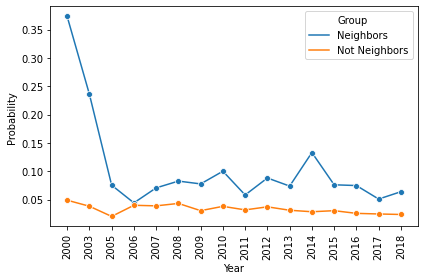

In [59]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig("../figures/probability_collaborations_1_year.png", dpi=300)

## 5 Years

In [60]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-5]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    chunk = chunk.groupby(['author1', 'author2']).size().rename('weight').reset_index()
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     edge_attr='weight',
                                     create_using=nx.Graph)
    degree_year = pd.DataFrame(G_year.degree(weight='weight'), columns=['author', 'degree'])
    median = degree_year.degree.mean()
    dic_neighbors = {}
    for sc in super_cited[i]:
        if sc in G_year:
            for u in G_year[sc]:
                w = G_year[sc][u]['weight']
                dic_neighbors.setdefault(u, [])
                dic_neighbors[u].append(w)
    dic_neighbors = {u: sum(dic_neighbors[u]) for u in dic_neighbors if sum(dic_neighbors[u]) >= median}
    n = set(dic_neighbors.keys())
    if i == 0:
        n = n - super_cited[i]
        not_n = set(list(G_year)) - n - super_cited[i] 
    else:
        for j in range(0, i+1):
            n = n - super_cited[j]
            not_n = set(list(G_year)) - n - super_cited[j]
    print("neighbors\n", all_people[all_people['Short-Id'].isin(n)]['gender'].value_counts(normalize=True).loc['female'])
    print("not_neighbors\n", all_people[all_people['Short-Id'].isin(not_n)]['gender'].value_counts(normalize=True).loc['female'])
    neighbors.append(len(n & super_cited[i+5]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+5]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

neighbors
 0.07111111111111111
not_neighbors
 0.15301545107160658
neighbors
 0.116
not_neighbors
 0.18243132094094425
neighbors
 0.19597989949748743
not_neighbors
 0.20126367699183234
neighbors
 0.20588235294117646
not_neighbors
 0.19526285384171
neighbors
 0.11764705882352941
not_neighbors
 0.2032520325203252
neighbors
 0.2018348623853211
not_neighbors
 0.21706633447524135
neighbors
 0.25862068965517243
not_neighbors
 0.2351244687310261
neighbors
 0.18333333333333332
not_neighbors
 0.23848660904066885
neighbors
 0.22580645161290322
not_neighbors
 0.232589405754235
neighbors
 0.22641509433962265
not_neighbors
 0.24207269914926527
neighbors
 0.21658986175115208
not_neighbors
 0.2413535705399353
neighbors
 0.20809248554913296
not_neighbors
 0.24329382407985028


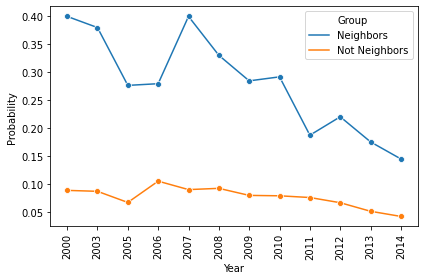

In [61]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig("../figures/probability_collaborations_5_years.png", dpi=300)

## How diversified you are in the super-cited group?

## After 1 year

In [62]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-1]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    chunk = chunk.groupby(['author1', 'author2']).size().rename('weight').reset_index()
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     edge_attr='weight',
                                     create_using=nx.Graph)
    dic_neighbors = {}
    for sc in super_cited[i]:
        if sc in G_year:
            for u in G_year[sc]:
                dic_neighbors.setdefault(u, [])
                dic_neighbors[u].append(sc)
    dic_neighbors = {u: len(dic_neighbors[u]) for u in dic_neighbors}
    mean = np.mean(list(dic_neighbors.values()))
    n = {u for u in dic_neighbors if dic_neighbors[u] >= mean}
    if i == 0:
        n = n - super_cited[i]
        not_n = set(list(G_year)) - n - super_cited[i] 
    else:
        for j in range(0, i+1):
            n = n - super_cited[j]
            not_n = set(list(G_year)) - n - super_cited[j]
    neighbors.append(len(n & super_cited[i+1]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+1]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

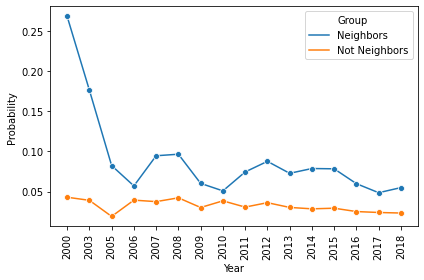

In [63]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig("../figures/probability_neighbors_1_year.png", dpi=300)

## After 5 years

In [64]:
neighbors = []
not_neighbors = []
for i, year in enumerate(years[:-5]):
    if year == 2000:
        chunk = col[col.year <= year]
    elif year == 2003:
        chunk = col[(col.year > 2000) & (col.year <= 2003)]
    elif year == 2005:
        chunk = col[(col.year > 2003) & (col.year <= 2005)]
    else:
        chunk = col[col.year == year]
    chunk = chunk.groupby(['author1', 'author2']).size().rename('weight').reset_index()
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="author1",
                                     target="author2",
                                     edge_attr='weight',
                                     create_using=nx.Graph)
    dic_neighbors = {}
    for sc in super_cited[i]:
        if sc in G_year:
            for u in G_year[sc]:
                dic_neighbors.setdefault(u, [])
                dic_neighbors[u].append(sc)
    dic_neighbors = {u: len(dic_neighbors[u]) for u in dic_neighbors}
    mean = np.mean(list(dic_neighbors.values()))
    n = {u for u in dic_neighbors if dic_neighbors[u] >= mean}
    if i == 0:
        n = n - super_cited[i]
        not_n = set(list(G_year)) - n - super_cited[i] 
    else:
        for j in range(0, i+1):
            n = n - super_cited[j]
            not_n = set(list(G_year)) - n - super_cited[j]
    neighbors.append(len(n & super_cited[i+5]) / len(n))
    not_neighbors.append(len(not_n & super_cited[i+5]) / len(not_n))

data = []
for i, r in enumerate(neighbors):
    data.append([str(years[i]), r, 'Neighbors'])
for i, r in enumerate(not_neighbors):
    data.append([str(years[i]), r, 'Not Neighbors'])
    
df = pd.DataFrame(data, columns=['Year', 'Probability', 'Group'])

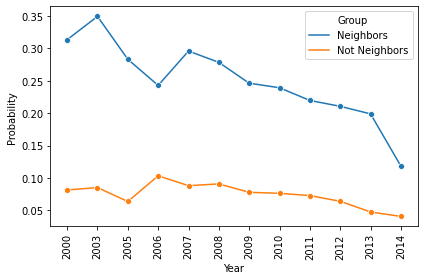

In [65]:
sns.lineplot(x='Year', y='Probability', hue='Group', data=df, marker="o")
plt.xticks(rotation=90)
plt.tight_layout()
# plt.savefig("../figures/probability_neighbors_5_years.png", dpi=300)